In [ ]:
import csv
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, classification_report, roc_auc_score, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, matthews_corrcoef, ConfusionMatrixDisplay
from sklearn.dummy import DummyClassifier
import xgboost as xgb
import random
import zipfile
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# ====================================
# Step 1: Load Data
# ====================================
# Set the dataset name
csv_path_train = '/content/drive/MyDrive/AllergenAI-new/data/1280_dim_ESM-2_embeddings/algpred2_train_esm2_1280dim_embeddings.csv'
csv_path_test = '/content/drive/MyDrive/AllergenAI-new/data/1280_dim_ESM-2_embeddings/algpred2_test_esm2_1280dim_embeddings.csv'
# Construct embedding file paths based on dataset name
embedding_files = {
    "train": csv_path_train,
    "test": csv_path_test
}

# Load the data
df_train = pd.read_csv(embedding_files["train"])
df_test = pd.read_csv(embedding_files["test"])


feature_cols = [f"f{i}" for i in range(1280)]
X_train_full = df_train[feature_cols].values
y_train_full = df_train["label"].values

X_test = df_test[feature_cols].values
y_test = df_test["label"].values

print(f"✅ Loaded: Train={X_train_full.shape}, Test={X_test.shape}")

# ====================================
# Step 2: Dummy Classifier Baseline (on Train)
# ====================================
# print("\n📉 DummyClassifier (Stratified) on Training Set (CV):\n")
# dummy = DummyClassifier(strategy="stratified", random_state=42)
# dummy_aucs = []
# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# for train_idx, val_idx in cv.split(X_train_full, y_train_full):
#     dummy.fit(X_train_full[train_idx], y_train_full[train_idx])
#     y_dummy_proba = dummy.predict_proba(X_train_full[val_idx])[:, 1]
#     auc = roc_auc_score(y_train_full[val_idx], y_dummy_proba)
#     dummy_aucs.append(auc)

# print(f"📊 Dummy ROC-AUC: {np.mean(dummy_aucs):.4f} ± {np.std(dummy_aucs):.4f}")

✅ Loaded: Train=(16120, 1280), Test=(4030, 1280)


In [ ]:
# ====================================
# Step 3: Cross-Validation on Training Set (XGBoost)
# ====================================

print("\n🔍 Grid Search with 5-Fold Cross-Validation (XGBoost)...\n")

# Define parameter grid
param_grid = {
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Create base classifier
xgb_base = xgb.XGBClassifier(
    use_label_encoder=False,
    eval_metric="logloss",
    random_state=42
)

# GridSearchCV with 5-fold CV
grid_search = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Fit on full training data (GridSearchCV handles internal CV)
grid_search.fit(X_train_full, y_train_full)

# Best Parameter
print(f"✅ Best Parameters: {grid_search.best_params_}")

# Extract cross-validated performance of the best model
cv_results = grid_search.cv_results_

# Find index of best model
best_index = grid_search.best_index_

# Extract metrics
mean_auc = cv_results['mean_test_score'][best_index]
std_auc = cv_results['std_test_score'][best_index]

print("\n📊 Cross-Validation Performance of Best Model:")
print(f"    Mean CV ROC-AUC: {mean_auc:.4f} ± {std_auc:.4f}")

In [ ]:
# Best model
best_model = xgb.XGBClassifier(
    use_label_encoder=False,
    eval_metric="logloss",
    random_state=42,
    colsample_bytree=0.8,
    learning_rate=0.1,
    max_depth=5,
    n_estimators=200,
    subsample=1.0
)

In [ ]:
# ====================================
# Step 4: Final Test Set Evaluation
# ====================================
print("\n🔒 Final Evaluation on Hold-Out Test Set...\n")
clf_final = best_model

clf_final.fit(X_train_full, y_train_full)

y_test_pred = clf_final.predict(X_test)
y_test_proba = clf_final.predict_proba(X_test)[:, 1]


# Metrics
test_auc = roc_auc_score(y_test, y_test_proba)
test_acc = accuracy_score(y_test, y_test_pred)
test_prec = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_mcc = matthews_corrcoef(y_test, y_test_pred)

# Specificity from confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
tn, fp, fn, tp = cm.ravel()
test_specificity = tn / (tn + fp)

# Print the metrics
print("📊 Final Test Set Metrics:")
print(f"    ROC-AUC     : {test_auc:.4f}")
print(f"    Accuracy    : {test_acc:.4f}")
print(f"    Precision   : {test_prec:.4f}")
print(f"    Recall      : {test_recall:.4f}")
print(f"    F1 Score    : {test_f1:.4f}")
print(f"    Specificity : {test_specificity:.4f}")
print(f"    MCC         : {test_mcc:.4f}")


🔒 Final Evaluation on Hold-Out Test Set...



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:39:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


📊 Final Test Set Metrics:
    ROC-AUC     : 0.9811
    Accuracy    : 0.8762
    Precision   : 0.9871
    Recall      : 0.7623
    F1 Score    : 0.8603
    Specificity : 0.9901
    MCC         : 0.7727


In [ ]:
# ====================================
# Step 5: Y-Scrambling Control
# ====================================
print("\n🧪 Y-Scrambling (sanity check) on Training Set...\n")
y_scrambled = y_train_full.copy()
random.seed(42)
random.shuffle(y_scrambled)

scrambled_aucs = []
for train_idx, val_idx in cv.split(X_train_full, y_scrambled):
    X_train, X_val = X_train_full[train_idx], X_train_full[val_idx]
    y_train, y_val = y_scrambled[train_idx], y_scrambled[val_idx]

    clf_scrambled = best_model
    clf_scrambled.fit(X_train, y_train)
    y_proba_scrambled = clf_scrambled.predict_proba(X_val)[:, 1]

    auc = roc_auc_score(y_val, y_proba_scrambled)
    scrambled_aucs.append(auc)

print(f"🔀 Y-Scrambled ROC-AUC: {np.mean(scrambled_aucs):.4f} ± {np.std(scrambled_aucs):.4f}")
print("👉 This should be near 0.5 if your real model learned something.")


🧪 Y-Scrambling (sanity check) on Training Set...



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:14:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:15:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:17:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:18:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:19:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

🔀 Y-Scrambled ROC-AUC: 0.4903 ± 0.0128
👉 This should be near 0.5 if your real model learned something.



🔥 SHAP Analysis...



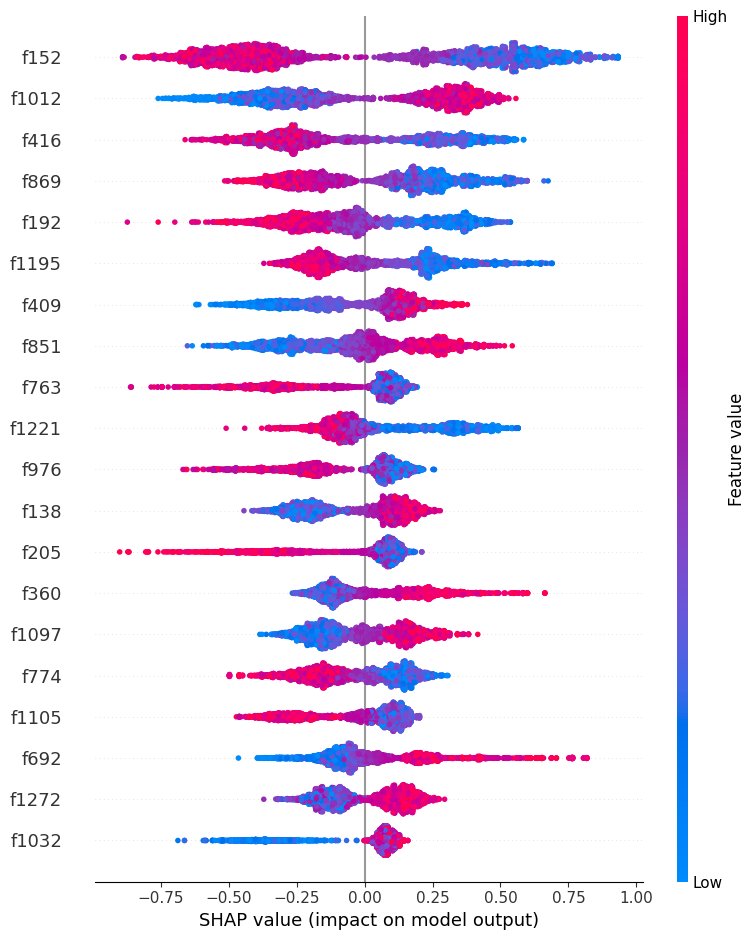

In [ ]:
# ====================================
# Step 🔥: SHAP Analysis
# ====================================
print("\n🔥 SHAP Analysis...\n")

# Create a SHAP explainer
explainer = shap.TreeExplainer(clf_final)

# Calculate SHAP values
shap_values = explainer.shap_values(X_test)

# Summary plot (global feature importance)
shap.summary_plot(shap_values, X_test, feature_names=feature_cols)



🧩 Confusion Matrix...



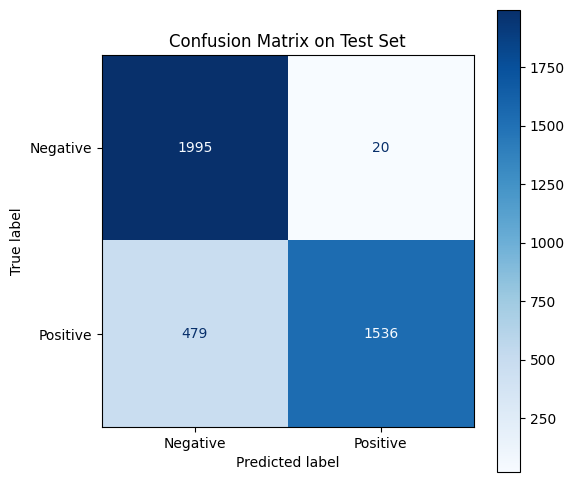

In [ ]:
# ====================================
# Step Y: Confusion Matrix
# ====================================
print("\n🧩 Confusion Matrix...\n")

cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])

fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap="Blues", values_format="d", ax=ax)
plt.title("Confusion Matrix on Test Set")
plt.grid(False)
plt.show()
